# Example

In [2]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
class GeneralClassifier:
    # covariance for each class is arbitrary
    def __init__(self, mean1, mean2, cov1, cov2, apriori1, apriori2):
        self.mean1 = mean1
        self.mean2 = mean2
        self.cov1 = cov1
        self.cov2 = cov2
        self.apriori1 = apriori1
        self.apriori2 = apriori2
        
    def predict(self, X):
        labels = []
        for x in X:
            diff1 = x-self.mean1
            diff2 = x-self.mean2
            
            g1 = -0.5*np.dot(np.dot(diff1,np.linalg.inv(self.cov1)),diff1)
            -0.5*np.log(np.linalg.det(self.cov1))+np.log(self.apriori1)
            
            g2 = -0.5*np.dot(np.dot(diff2,np.linalg.inv(self.cov2)),diff2)
            -0.5*np.log(np.linalg.det(self.cov2))+np.log(self.apriori2)
            
            if g1 > g2:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(labels)

class QuadraticDiscriminant:
    def __init__(self, mean1, mean2, cov1, cov2, apriori1, apriori2):
        self.mean1 = mean1
        self.mean2 = mean2
        self.cov1 = cov1
        self.cov2 = cov2
        self.apriori1 = apriori1
        self.apriori2 = apriori2
        
        conv1_inv = np.linalg.inv(self.cov1)
        conv2_inv = np.linalg.inv(self.cov2)
        
        self.W1 = -0.5*conv1_inv
        self.W2 = -0.5*conv2_inv
        self.w1 = np.dot(conv1_inv,self.mean1)
        self.w2 = np.dot(conv2_inv,self.mean2)
        
        part11 = -0.5*np.dot(np.dot(self.mean1, conv1_inv),self.mean1)
        part12 = -0.5*np.log(np.linalg.det(conv1_inv))+np.log(self.apriori1)
        self.w10 = part11 + part12
        
        part21 = -0.5*np.dot(np.dot(self.mean2, conv2_inv),self.mean2)
        part22 = -0.5*np.log(np.linalg.det(conv2_inv))+np.log(self.apriori2)
        self.w20 = part21 + part22
        
    def predict(self, X):
        labels = []
        for x in X:
            g1 = np.dot(np.dot(x,self.W1),x)+np.dot(self.w1,x)+self.w10
            g2 = np.dot(np.dot(x,self.W2),x)+np.dot(self.w2,x)+self.w20
            
            if g1 > g2:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(labels)
    
def calcError(classifier, X, Y):
    # calculate the number of misclassified samples separately and in total
    miss_total = 0
    miss_class1 = 0
    miss_class2 = 0
    predicted_labels = classifier.predict(X)
    
    for n in range(Y.size):
        if predicted_labels[n] != Y[n]:
            if Y[n] == 0:
                miss_class1 += 1
            elif Y[n] == 1:
                miss_class2 += 1

    miss_total = miss_class1 + miss_class2

    print "# of miss classifications for class1 = %d" %(miss_class1)
    print "# of miss classifications for class2 = %d" %(miss_class2)
    print "# of miss classifications = %d" %(miss_total)
    
def visualize(classifier, X, Y, ax):
    # Show how points in a grid would be classified
    h = 0.05 # mesh size
    x_min, x_max = X[:, 0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap='cool')
    
    # Plots the training data
    ax.scatter(X[:,0],  X[:,1], c = Y, cmap='cool')
    
# error bounds
def kb(beta, mean1, mean2, cov1, cov2):
    diff = mean1 - mean2
    covline = (1-beta)*cov1+beta*cov2
    part1 =  beta*(1-beta)/2.0*np.dot(np.dot(np.linalg.inv(covline),diff),diff)
    part2 = 0.5*(np.log(np.linalg.det(covline)) - np.log(np.linalg.det(cov1)**(1-beta)*np.linalg.det(cov2)**beta))
    kb = part1 + part2
    return kb

def ekb(beta, mean1, mean2, cov1, cov2):
    return np.exp(-kb(beta, mean1, mean2, cov1, cov2))

def chernoff(beta, apriori1, apriori2, ekb):
    return (apriori1**beta)*(apriori2**(1-beta))*ekb
    
def bhattacharyya(apriori1, apriori2, ekb):
    return sqrt(apriori1*apriori2)*ekb

In [7]:
# input files
sample_set1 = np.loadtxt("../sample_data/Example2")
print sample_set1

sample_set2 = np.loadtxt("../sample_data/Example2")
print sample_set2

example_case = np.vstack((sample_set1,sample_set2))
print example_case.shape
labels = np.array([0]*10000 + [1]*10000)

[[ 2.93943  -2.52027 ]
 [ 2.39423  -3.2476  ]
 [ 3.99887  -3.51832 ]
 ..., 
 [ 4.72021  -0.661033]
 [-0.808214 -1.91636 ]
 [ 2.29501  -2.08715 ]]
[[ 2.93943  -2.52027 ]
 [ 2.39423  -3.2476  ]
 [ 3.99887  -3.51832 ]
 ..., 
 [ 4.72021  -0.661033]
 [-0.808214 -1.91636 ]
 [ 2.29501  -2.08715 ]]
(20000, 2)


In [8]:
# classification
mean1 = np.array([3.,6.])
mean2 = np.array([3.,-2.])
cov1 = np.array([[0.5,0],[0,2.]])
cov2 = np.array([[2.,0],[0,2.]])
apriori1 = 0.5
apriori2 = 0.5

classifier_ex = QuadraticDiscriminant(mean1, mean2, cov1, cov2, apriori1, apriori2)

# calc miss classification
calcError(classifier_ex, example_case, labels)

# of miss classifications for class1 = 9989
# of miss classifications for class2 = 11
# of miss classifications = 10000


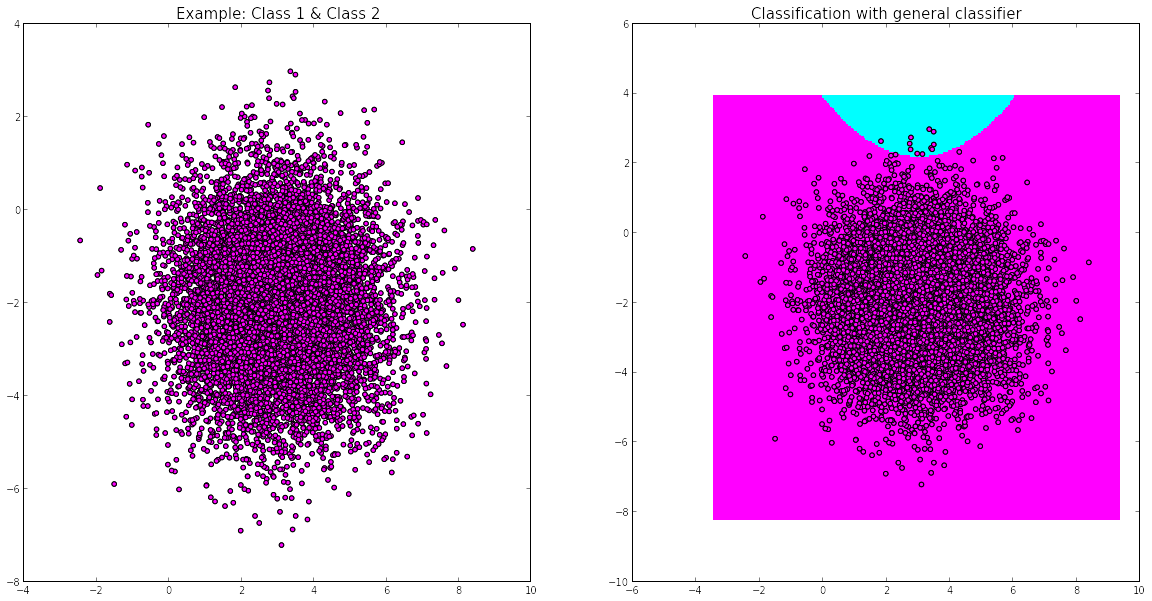

In [9]:
# plot
f, axarr = subplots(1, 2,figsize=(20, 10))
axarr[0].set_title("Example: Class 1 & Class 2", fontsize=15)
axarr[0].scatter(example_case[:,0], example_case[:,1], c=labels, cmap='cool')

axarr[1].set_title("Classification with general classifier", fontsize=15)
visualize(classifier_ex, example_case, labels, axarr[1])

Bhattacharyya error: k(0.5) = 4.111572
P(error) <= 0.008191


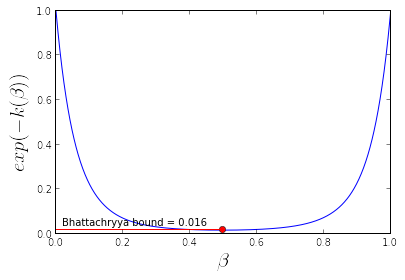

In [8]:
betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov1, cov2)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

# plot bounds
beta = 0.5
ekb_value = ekb(beta, mean1, mean2, cov1, cov2)
plot(beta,ekb_value,'ro')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'r')
plot([beta]*2,np.linspace(0,ekb_value,2), 'r')
text(0.02, ekb_value+0.02, "Bhattachryya bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)

print "Bhattacharyya error: k(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %bhattacharyya(0.5, 0.5, ekb_value)